In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
import modplot
import numpy as np
import ibu
intum=3
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
import tensorflow.keras.backend as K

/Users/claudiumihai/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [162]:
inputs = Input((6, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(2, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import energyflow as ef
import energyflow.archs


In [6]:
datasets = {'Pythia26': ef.zjets_delphes.load('Pythia26', num_data=1000000, exclude_keys=['particles']),
            'Herwig': ef.zjets_delphes.load('Herwig', num_data=1200000, exclude_keys=['particles'])}
synthetic, nature = datasets['Pythia26'], datasets['Herwig']


In [19]:
obs_multifold = ['Mass', 'Mult', 'Width', 'Tau21', 'zg', 'SDMass']
# a dictionary to hold information about the observables
obs = {}

# the jet mass and histogram style information
obs.setdefault('Mass', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_jets'][:,3],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 75), 'ylim': (0, 0.065),
    'xlabel': r'Jet Mass $m$ [GeV]', 'symbol': r'$m$',
    'ylabel': r'Normalized Cross Section [GeV$^{-1}$]',
    'stamp_xy': (0.425, 0.65),
})

# the constituent multiplicity and histogram style information
obs.setdefault('Mult', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_mults'],
    'nbins_det': 80, 'nbins_mc': 80,
    'xlim': (0, 80), 'ylim': (0, 0.065),
    'xlabel': 'Jet Constituent Multiplicity $M$', 'symbol': r'$M$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.42, 0.65),
})

# the jet width and histogram style information
obs.setdefault('Width', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_widths'],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 0.6), 'ylim': (0, 10),
    'xlabel': r'Jet Width $w$', 'symbol': r'$w$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.425, 0.65),
})

# the N-subjettiness ratio and histogram style information
obs.setdefault('Tau21', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_tau2s']/(dset[ptype + '_widths'] + 10**-50),
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 1.2), 'ylim': (0, 3),
    'xlabel': r'$N$-subjettiness Ratio $\tau_{21}^{(\beta=1)}$', 'symbol': r'$\tau_{21}^{(\beta=1)}$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.41, 0.92),
    'legend_loc': 'upper left', 'legend_ncol': 1,
})

# the groomed momentum fraction and histogram style information
obs.setdefault('zg', {}).update({
    'func': lambda dset, ptype: dset[ptype + '_zgs'],
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (0, 0.5), 'ylim': (0, 9),
    'xlabel': r'Groomed Jet Momentum Fraction $z_g$', 'symbol': r'$z_g$',
    'ylabel': 'Normalized Cross Section',
    'stamp_xy': (0.425, 0.65),
})

# the groomed jet mass and histogram style information
obs.setdefault('SDMass', {}).update({
    'func': lambda dset, ptype: np.log(dset[ptype + '_sdms']**2/
                                       dset[ptype + '_jets'][:,0]**2 + 10**-100),
    'nbins_det': 50, 'nbins_mc': 50,
    'xlim': (-14, -2), 'ylim': (0, 0.3),
    'xlabel': r'Soft Drop Jet Mass $\ln\rho$', 'symbol': r'$\ln\rho$',
    'ylabel': r'Normalized Cross Section',
    'stamp_xy': (0.41, 0.92),
    'legend_loc': 'upper left', 'legend_ncol': 1,
})

# additional histogram and plot style information
hist_style = {'histtype': 'step', 'density': True, 'lw': 1, 'zorder': 2}
gen_style = {'linestyle': '--', 'color': 'blue', 'lw': 1.15, 'label': 'Gen.'}
truth_style = {'step': 'mid', 'edgecolor': 'green', 'facecolor': (0.75, 0.875, 0.75),
               'lw': 1.25, 'zorder': 0, 'label': '``Truth\"'}
ibu_style = {'ls': '-', 'marker': 'o', 'ms': 2.5, 'color': 'gray', 'zorder': 1}
omnifold_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:red', 'zorder': 3}

In [20]:
itnum=3

In [21]:
# calculate quantities to be stored in obs
for obkey,ob in obs.items():
    
    # calculate observable for GEN, SIM, DATA, and TRUE
    ob['genobs'], ob['simobs'] = ob['func'](synthetic, 'gen'), ob['func'](synthetic, 'sim')
    ob['truthobs'], ob['dataobs'] = ob['func'](nature, 'gen'), ob['func'](nature, 'sim')
    
    # setup bins
    ob['bins_det'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_det']+1)
    ob['bins_mc'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_mc']+1)
    ob['midbins_det'] = (ob['bins_det'][:-1] + ob['bins_det'][1:])/2
    ob['midbins_mc'] = (ob['bins_mc'][:-1] + ob['bins_mc'][1:])/2
    ob['binwidth_det'] = ob['bins_det'][1] - ob['bins_det'][0]
    ob['binwidth_mc'] = ob['bins_mc'][1] - ob['bins_mc'][0]
    
    # get the histograms of GEN, DATA, and TRUTH level observables
    ob['genobs_hist'] = np.histogram(ob['genobs'], bins=ob['bins_mc'], density=True)[0]
    ob['data_hist'] = np.histogram(ob['dataobs'], bins=ob['bins_det'], density=True)[0]
    ob['truth_hist'], ob['truth_hist_unc'] = modplot.calc_hist(ob['truthobs'], bins=ob['bins_mc'], 
                                                               density=True)[:2]

    # compute (and normalize) the response matrix between GEN and SIM
    ob['response'] = np.histogram2d(ob['simobs'], ob['genobs'], bins=(ob['bins_det'], ob['bins_mc']))[0]
    ob['response'] /= (ob['response'].sum(axis=0) + 10**-50)
    
    # perform iterative Bayesian unfolding
    ob['ibu_phis'] = ibu.ibu(ob['data_hist'], ob['response'], ob['genobs_hist'], 
                         ob['binwidth_det'], ob['binwidth_mc'], it=itnum)
    ob['ibu_phi_unc'] = ibu.ibu_unc(ob, it=itnum, nresamples=25)
   # 
    print('Done with', obkey)

Done with Mass
Done with Mult
Done with Width
Done with Tau21
Done with zg
Done with SDMass


In [66]:
model_layer_sizes = [100, 100]
import numpy as np
# model_layer_sizes = [100, 100, 100] # use this for the full network size

# set up the array of data/simulation detector-level observables
X_det = np.asarray([np.concatenate((obs[obkey]['dataobs'], obs[obkey]['simobs'][:800000])) for obkey in obs_multifold]).T
Y_det = ef.utils.to_categorical(np.concatenate((np.ones(len(obs['Mass']['dataobs'])), 
                                               np.zeros(len(obs['Mass']['simobs'][:800000])) )))


# set up the array of generation particle-level observables
X_gen = np.asarray([np.concatenate((obs[obkey]['genobs'], obs[obkey]['genobs'])) for obkey in obs_multifold]).T
Y_gen = ef.utils.to_categorical(np.concatenate((np.ones(len(obs['Mass']['genobs'])), 
                                                np.zeros(len(obs['Mass']['genobs'])))))

# standardize the inputs
#X_det = (X_det - np.mean(X_det, axis=0))/np.std(X_det, axis=0)
#X_gen = (X_gen - np.mean(X_gen, axis=0))/np.std(X_gen, axis=0)

# Specify the training parameters
# model parameters for the Step 1 network
det_args = {'input_dim': len(obs_multifold), 'dense_sizes': model_layer_sizes,
            'patience': 10, 'filepath': 'Step1_{}', 'save_weights_only': False, 
            'modelcheck_opts': {'save_best_only': True, 'verbose': 1}}

# model parameters for the Step 2 network
mc_args = {'input_dim': len(obs_multifold), 'dense_sizes': model_layer_sizes, 
           'patience': 10, 'filepath': 'Step2_{}', 'save_weights_only': False, 
           'modelcheck_opts': {'save_best_only': True, 'verbose': 1}}

# general training parameters
fitargs = {'batch_size': 500, 'epochs': 2, 'verbose': 1}
#fitargs = {'batch_size': 500, 'epochs': 100, 'verbose': 1} # use this for a full training

# reweight the sim and data to have the same total weight to begin with
ndata, nsim = np.count_nonzero(Y_det[:,1]), np.count_nonzero(Y_det[:,0])
wdata = np.ones(ndata)
winit = ndata/nsim*np.ones(nsim)

In [69]:
Y_det

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [70]:
import pandas as pd
temp=np.asarray([obs[obkey]['simobs'] for obkey in obs_multifold]).T
Sim_particle=pd.DataFrame(temp)
#Sim_detector=pd.DataFrame(temp)\
efficiency=Sim_particle.sample(n=200000,random_state=30)
Sim_detector=Sim_particle.drop(efficiency.index)

In [ ]:
event_particle=np.array(Sim_particle.index)

In [ ]:
event_detector=np.array(Sim_detector.index)

In [74]:
common_events=np.where(np.isin(event_particle,np.intersect1d(event_detector,event_particle)))[0]

In [75]:
different_events=np.where(~np.isin(event_particle,np.intersect1d(event_detector,event_particle)))[0]

In [243]:
X_det = np.asarray([np.concatenate((obs[obkey]['dataobs'], obs[obkey]['simobs'][common_events])) for obkey in obs_multifold]).T
Y_det = ef.utils.to_categorical(np.concatenate((np.ones(len(obs['Mass']['dataobs'])), 
                                               np.zeros(len(obs['Mass']['simobs'][common_events])) )))

ndata, nsim = np.count_nonzero(Y_det[:,1]), np.count_nonzero(Y_det[:,0])
wdata = np.ones(ndata)
winit = ndata/nsim*np.ones(nsim)

X_diff = np.asarray([obs[obkey]['genobs'][different_events]for obkey in obs_multifold]).T

#Y_diff=ef.utils.to_categorical(np.concatenate((np.ones(len(obs['Mass']['dataobs'][different_events])), 
#                                               np.zeros(len(obs['Mass']['simobs'][different_events])) )))

X_com = np.asarray([np.concatenate((obs[obkey]['genobs'][common_events], obs[obkey]['genobs'][common_events])) for obkey in obs_multifold]).T
Y_com=ef.utils.to_categorical(np.concatenate((np.ones(len(obs['Mass']['genobs'][common_events])), 
                                               np.zeros(len(obs['Mass']['genobs'][common_events])) )))

X_gen= np.asarray([np.concatenate((obs[obkey]['genobs'], obs[obkey]['genobs'])) for obkey in obs_multifold]).T
Y_gen=ef.utils.to_categorical(np.concatenate((np.ones(len(obs['Mass']['genobs'])), 
                                               np.zeros(len(obs['Mass']['genobs'])) )))


In [246]:
X_det[1200000:,].shape

(800000, 6)

In [247]:
weights_push=np.ones(1000000)
weights_pull=np.ones(1000000)
sub_method=1
e=20
weights_push[common_events]=winit
w_dict={}
w_dict={'push':{'0':weights_push},'pull':{'0':weights_pull}}
for i in range(itnum):
    w=np.concatenate((np.ones(1200000),weights_push[common_events]))
    X_train,X_test,y_train,y_test,w_train,w_test=train_test_split(X_det,Y_det,w)
    model.compile(loss=BinaryCrossentropy,optimizer='Adam',metrics=['accuracy'])

    model.fit(X_train,y_train,sample_weight=w_train,epochs=e,batch_size=10000,validation_data=(X_test,y_test,w_test),verbose=False)

    f=model.predict(X_det[1200000:,],batch_size=10000)
    print(f)
    temp=f[:,0]/f[:,1]
    weights_pull[common_events]=weights_push[common_events]*temp
    print(temp)

    if sub_method==1:
        w_eff=np.concatenate((weights_pull[common_events],np.ones(len(common_events))))
    else:
        w_eff=np.concatenate((weights_pull[common_events],weights_push[common_events]))


    X_eff_train, X_eff_test, y_eff_train, y_eff_test, w_eff_train, w_eff_test = train_test_split(X_com,Y_com,w_eff)

    model.compile(loss=BinaryCrossentropy,optimizer='Adam',metrics=['accuracy'])

    model.fit(X_eff_train,y_eff_train,sample_weight=w_eff_train,epochs=e,batch_size=10000,validation_data=(X_eff_test,y_eff_test,w_eff_test),verbose=False)
    
    f=model.predict(X_diff,batch_size=10000)

    average_weight=f[:,0]/f[:,1]

    weights_pull[different_events]=average_weight

    w_dict['pull'].update({str(i+1):weights_pull})
    
    w2=np.concatenate((weights_pull,weights_push))


    X_train_2,X_test_2,y_train_2,y_test_2,w_train_2,w_test_2=train_test_split(X_gen,Y_gen,w2)

    model.compile(loss=BinaryCrossentropy,optimizer='Adam',metrics=['accuracy'])

    model.fit(X_train_2,y_train_2,sample_weight=w_train_2,epochs=e,batch_size=10000,validation_data=(X_test_2,y_test_2,w_test_2),verbose=False)

    f1=model.predict(X_gen[:1000000,],batch_size=10000)
    
    temp1=f1[:,0]/f1[:,1]

    weights_push=weights_push*temp1
    w_dict['push'].update({str(i+1):weights_push})


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[nan nan]
 [nan nan]
 [nan nan]
 ...
 [nan nan]
 [nan nan]
 [nan nan]]
[nan nan nan ... nan nan nan]


KeyboardInterrupt: 

In [186]:
def omnifold_m1(X_det,Y_det,X_gen,Y_gen,itnum,e):
    weights_push=np.ones(1000000)
    weights_pull=np.ones(1000000)

    weights_push[common_events]=winit
    w_dict={}
    w_dict={'push':{'0':weights_push},'pull':{'0':weights_pull}}
    for i in range(itnum):
        w=np.concatenate((np.ones(1200000),weights_push[common_events]))
        X_train,X_test,y_train,y_test,w_train,w_test=train_test_split(X_det,Y_det,w)
        model.compile(loss=BinaryCrossentropy,optimizer='Adam',metrics=['accuracy'])

        model.fit(X_train,y_train,sample_weight=w_train,epochs=e,batch_size=10000,validation_data=(X_test,y_test,w_test),verbose=False)

        f=model.predict(X_det[1200000:,],batch_size=10000)
     
        temp=f[:,0]/f[:,1]
        #print(temp)
        weights_pull[common_events]=weights_push[common_events]*temp


        weights_pull[different_events]=1

        #print(weights_pull)
        w_dict['pull'].update({str(i+1):weights_pull})
        
        w2=np.concatenate((weights_pull,weights_push))


        X_train_2,X_test_2,y_train_2,y_test_2,w_train_2,w_test_2=train_test_split(X_gen,Y_gen,w2)

        model.compile(loss=BinaryCrossentropy,optimizer='Adam',metrics=['accuracy'])

        model.fit(X_train_2,y_train_2,sample_weight=w_train_2,epochs=e,batch_size=10000,validation_data=(X_test_2,y_test_2,w_test_2),verbose=False)

        f1=model.predict(X_gen[:1000000,],batch_size=10000)
        
        temp1=f1[:,0]/f1[:,1]

        weights_push=weights_push*temp1
        w_dict['push'].update({str(i+1):weights_push})
    return weights_push
    

In [236]:
def omnifold_m2(X_det,Y_det,X_gen,Y_gen,X_com,Y_com,itnum,e,sub_method):
    weights_push=np.ones(1000000)
    weights_pull=np.ones(1000000)

    weights_push[common_events]=winit
    w_dict={}
    w_dict={'push':{'0':weights_push},'pull':{'0':weights_pull}}
    for i in range(itnum):
        w=np.concatenate((np.ones(1200000),weights_push[common_events]))
        X_train,X_test,y_train,y_test,w_train,w_test=train_test_split(X_det,Y_det,w)
        model.compile(loss=BinaryCrossentropy,optimizer='Adam',metrics=['accuracy'])

        model.fit(X_train,y_train,sample_weight=w_train,epochs=e,batch_size=10000,validation_data=(X_test,y_test,w_test),verbose=False)

        f=model.predict(X_det[1200000:,],batch_size=10000)
        
        temp=f[:,0]/f[:,1]
        weights_pull[common_events]=weights_push[common_events]*temp
        print(temp)

        if sub_method==1:
            w_eff=np.concatenate((weights_pull[common_events],np.ones(len(common_events))))
        else:
            w_eff=np.concatenate((weights_pull[common_events],weights_push[common_events]))


        X_eff_train, X_eff_test, y_eff_train, y_eff_test, w_eff_train, w_eff_test = train_test_split(X_com,Y_com,w_eff)

        model.compile(loss=BinaryCrossentropy,optimizer='Adam',metrics=['accuracy'])

        model.fit(X_eff_train,y_eff_train,sample_weight=w_eff_train,epochs=e,batch_size=10000,validation_data=(X_eff_test,y_eff_test,w_eff_test),verbose=False)
        
        f=model.predict(X_diff,batch_size=10000)

        average_weight=f[:,0]/f[:,1]

        weights_pull[different_events]=average_weight

        w_dict['pull'].update({str(i+1):weights_pull})
        
        w2=np.concatenate((weights_pull,weights_push))


        X_train_2,X_test_2,y_train_2,y_test_2,w_train_2,w_test_2=train_test_split(X_gen,Y_gen,w2)

        model.compile(loss=BinaryCrossentropy,optimizer='Adam',metrics=['accuracy'])

        model.fit(X_train_2,y_train_2,sample_weight=w_train_2,epochs=e,batch_size=10000,validation_data=(X_test_2,y_test_2,w_test_2),verbose=False)

        f1=model.predict(X_gen[:1000000,],batch_size=10000)
        
        temp1=f1[:,0]/f1[:,1]

        weights_push=weights_push*temp1
        w_dict['push'].update({str(i+1):weights_push})
    return weights_push


In [188]:
def omnifold_m3(X_det,Y_det,X_gen,X_com,Y_com,itnum,e):
    weights_push=np.ones(1000000)
    weights_pull=np.ones(1000000)

    weights_push[common_events]=winit
    w_dict={}
    w_dict={'push':{'0':weights_push},'pull':{'0':weights_pull}}
    for i in range(itnum):
        w=np.concatenate((np.ones(1200000),weights_push[common_events]))
        X_train,X_test,y_train,y_test,w_train,w_test=train_test_split(X_det,Y_det,w)
        model.compile(loss=BinaryCrossentropy,optimizer='Adam',metrics=['accuracy'])

        model.fit(X_train,y_train,sample_weight=w_train,epochs=e,batch_size=10000,validation_data=(X_test,y_test,w_test),verbose=False)

        f=model.predict(X_det[1200000:,],batch_size=10000)
     
        temp=f[:,0]/f[:,1]
        weights_pull[common_events]=weights_push[common_events]*temp

        
        
        w2=np.concatenate((weights_pull[common_events],weights_push[common_events]))
        

        X_train_2,X_test_2,y_train_2,y_test_2,w_train_2,w_test_2=train_test_split(X_com,Y_com,w2)

        model.compile(loss=BinaryCrossentropy,optimizer='Adam',metrics=['accuracy'])

        model.fit(X_train_2,y_train_2,sample_weight=w_train_2,epochs=e,batch_size=10000,validation_data=(X_test_2,y_test_2,w_test_2),verbose=False)

        f1=model.predict(X_gen[:1000000,],batch_size=10000)
        
        temp1=f1[:,0]/f1[:,1]

        weights_push=weights_push*temp1
        w_dict['push'].update({str(i+1):weights_push})
    return weights_push


In [189]:
weights_push=np.ones(1000000)
weights_pull=np.ones(1000000)

#X=np.vstack((theta_unknown_S.reshape(-1,1),theta0_S.reshape(-1,1)))
weights_push[common_events]=winit

In [190]:
#itnum=3
Method1_weights_3={'epochs_20':{},'epochs_40':{},'epochs_60':{},'epochs_80':{},'epochs_100':{}}
Method2_weights_3={'epochs_20':{},'epochs_40':{},'epochs_60':{},'epochs_80':{},'epochs_100':{}}
Method2_prime_weights_3={'epochs_20':{},'epochs_40':{},'epochs_60':{},'epochs_80':{},'epochs_100':{}}

Method3_weights_3={'epochs_20':{},'epochs_40':{},'epochs_60':{},'epochs_80':{},'epochs_100':{}}

In [237]:
epochs=[20,40,60,80,100]
for e in epochs:
    if e!=100:
        continue
    weights_push=np.ones(1000000)
    weights_pull=np.ones(1000000)

    weights_push[common_events]=winit
    
    #Method1_weights_3['epochs_'+str(e)]=omnifold_m1(X_det,Y_det,X_gen,Y_gen,3,e)
    Method2_weights_3['epochs_'+str(e)]=omnifold_m2(X_det,Y_det,X_gen,Y_gen,X_com,Y_com,3,e,1)
    break
    Method2_prime_weights_3['epochs_'+str(e)]=omnifold_m2(X_det,Y_det,X_gen,Y_gen,X_com,Y_com,3,e,2)
    
    Method3_weights_3['epochs_'+str(e)]=omnifold_m3(X_det,Y_det,X_gen,X_com,Y_com,3,e)
    

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[nan nan nan ... nan nan nan]


KeyboardInterrupt: 

In [232]:
Method2_weights_3

{'epochs_20': array([1.77299561, 1.47665319, 1.92468325, ..., 0.99192221, 2.2888632 ,
        0.63584868]),
 'epochs_40': array([1.66592559, 1.58613797, 1.95873945, ..., 0.82931294, 2.15013877,
        0.56520769]),
 'epochs_60': array([1.71039863, 1.46004636, 1.98086407, ..., 0.91991086, 2.2846475 ,
        0.60831397]),
 'epochs_80': array([7.96456767e-01, 2.48619361e+00, 3.02766329e-01, ...,
        1.13912074e-05, 1.46113071e+00, 6.60426955e-01]),
 'epochs_100': array([nan, nan, nan, ..., nan, nan, nan])}

In [118]:
weights_push=np.ones(1000000)
weights_pull=np.ones(1000000)

#X=np.vstack((theta_unknown_S.reshape(-1,1),theta0_S.reshape(-1,1)))
weights_push[common_events]=winit
#Y=np.concatenate((np.ones(len(theta_unknown_S)),np.zeros(len(theta0_S))))


#X2=np.concatenate((theta0_G.reshape(-1,1),theta0_G.reshape(-1,1)))
#Y2=np.concatenate((np.ones(len(theta0_G)),np.zeros(len(theta0_G))))
#X_det = (X_det - np.mean(X_det, axis=0))/np.std(X_det, axis=0)
#X_gen = (X_gen - np.mean(X_gen, axis=0))/np.std(X_gen, axis=0)
w_dict={}
w_dict={'push':{'0':weights_push},'pull':{'0':weights_pull}}
epochs=[20,40,60,80,100]
for e in epochs:
#fig, axes= plt.subplots(1,3,figsize=[15,7])
    for i in range(1):
        w=np.concatenate((np.ones(1200000),weights_push[common_events]))
        X_train,X_test,y_train,y_test,w_train,w_test=train_test_split(X_det,Y_det,w)
        model.compile(loss=BinaryCrossentropy,optimizer='Adam',metrics=['accuracy'])

        model.fit(X_train,y_train,sample_weight=w_train,epochs=e,batch_size=10000,validation_data=(X_test,y_test,w_test),verbose=False)

        f=model.predict(X_det[1200000:,],batch_size=10000)
        #temp=np.squeeze(np.nan_to_num(f/(1.-f)))
        #print(f)
        temp=f[:,0]/f[:,1]
        weights_pull[common_events]=weights_push[common_events]*temp


        
        w_eff=np.concatenate((weights_pull[common_events],np.ones(len(common_events))))

        X_eff_train, X_eff_test, y_eff_train, y_eff_test, w_eff_train, w_eff_test = train_test_split(X_com,Y_com,w_eff)

        model.compile(loss=BinaryCrossentropy,optimizer='Adam',metrics=['accuracy'])

        model.fit(X_eff_train,y_eff_train,sample_weight=w_eff_train,epochs=e,batch_size=10000,validation_data=(X_eff_test,y_eff_test,w_eff_test),verbose=False)
        
        f=model.predict(X_diff,batch_size=10000)

        average_weight=f[:,0]/f[:,1]

        weights_pull[different_events]=average_weight


        w_dict['pull'].update({str(i+1):weights_pull})
        


        w2=np.concatenate((weights_pull,weights_push))


        
        #y_pred=model.predict(X_test)[:,1]
        #fpr, tpr, _ = roc_curve(y_test[:, 1], y_pred)
        #roc_auc = auc(fpr, tpr)
        #axes[i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        #axes[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guess
        #axes[i].set_xlim([0.0, 1.0])
        #axes[i].set_ylim([0.0, 1.05])
        #axes[i].set_xlabel('False Positive Rate')
        #axes[i].set_ylabel('True Positive Rate')
        #axes[i].set_title('Step 1 '+'iteration '+str(i+1))
        #axes[i].legend(loc='lower right')
        


        X_train_2,X_test_2,y_train_2,y_test_2,w_train_2,w_test_2=train_test_split(X_gen,Y_gen,w2)

        model.compile(loss=BinaryCrossentropy,optimizer='Adam',metrics=['accuracy'])

        model.fit(X_train_2,y_train_2,sample_weight=w_train_2,epochs=e,batch_size=10000,validation_data=(X_test_2,y_test_2,w_test_2),verbose=False)

        f1=model.predict(X_gen[:1000000,],batch_size=10000)
        #temp1=np.squeeze(np.nan_to_num(f1/(1.-f1)))
        
        temp1=f1[:,0]/f1[:,1]

        weights_push=weights_push*temp1
        w_dict['push'].update({str(i+1):weights_push})

    Method2_prime_weights_3['epochs_'+str(e)]=weights_push


    
#plt.tight_layout()
#plt.show()

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2

KeyboardInterrupt: 

In [101]:
weights_pull[different_events].shape,X_diff.shape

((200000,), (200000, 6))

In [102]:
len(Method2_weights_3['epochs_100'])

0

In [ ]:
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'serif'


In [23]:
import yaml
Method3_weights_3={key:value.tolist() for key, value in Method3_weights_3.items()}
with open('/Users/claudiumihai/MPhys/NeuralNets/Weights_3_m3.yaml','w') as file:
    yaml.safe_dump(Method3_weights_3,file)

In [82]:
#itnum=3

Method1_weights={'epochs_20':{},'epochs_40':{},'epochs_60':{},'epochs_80':{},'epochs_100':{}}
Method2_weights={'epochs_20':{},'epochs_40':{},'epochs_60':{},'epochs_80':{},'epochs_100':{}}
Method3_weights={'epochs_20':{},'epochs_40':{},'epochs_60':{},'epochs_80':{},'epochs_100':{}}

16.756703079035493


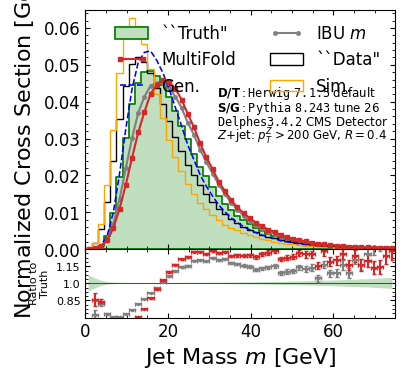

16.10224210825549


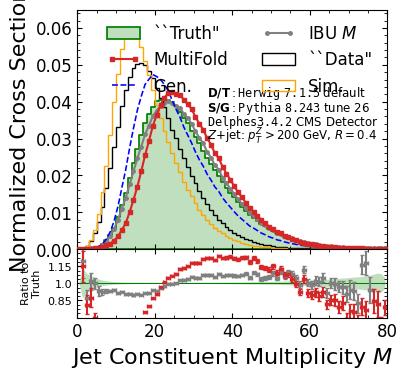

8.22112843806645


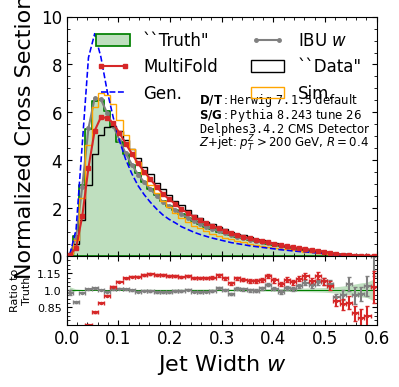

2.836920873197568


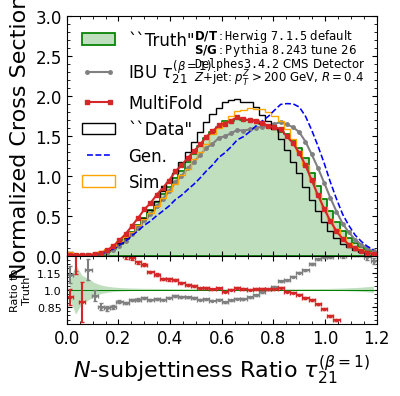

0.19060482982865018


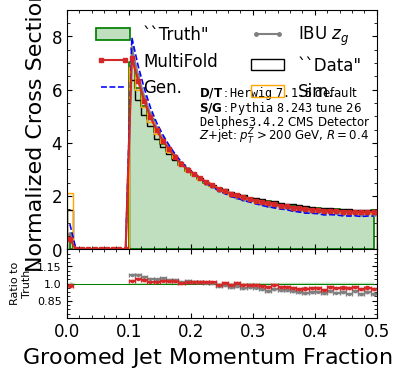

4.078318290377338


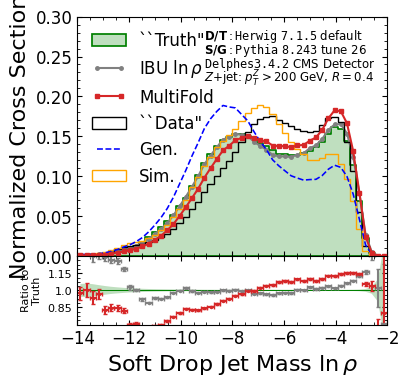

In [116]:
for i,(obkey,ob) in enumerate(obs.items()):
    
    # get the styled axes on which to plot
    fig, [ax0, ax1] = modplot.axes(**ob)
    if ob.get('yscale') is not None:
        ax0.set_yscale(ob['yscale'])

        
    # Plot the Different Distributions of the Observable
    # plot the "data" histogram of the observable
    ax0.hist(ob['dataobs'], bins=ob['bins_det'], color='black', label='``Data\"', **hist_style)

    # plot the "sim" histogram of the observable
    ax0.hist(ob['simobs'], bins=ob['bins_det'], color='orange', label='Sim.', **hist_style)

    # plot the "gen" histogram of the observable
    ax0.plot(ob['midbins_mc'], ob['genobs_hist'], **gen_style)

    # plot the "truth" histogram of the observable
    ax0.fill_between(ob['midbins_mc'], ob['truth_hist'], **truth_style)

    
    # Plot the Unfolded Distributions of the Observable
    # plot the OmniFold distribution
    of_histgen, of_histgen_unc = modplot.calc_hist(ob['genobs'], weights=Method2_weights_3['epochs_60'], 
                                                   bins=ob['bins_mc'], density=True)[:2]
    ax0.plot(ob['midbins_mc'], of_histgen, **omnifold_style, label='MultiFold')

    # plot the IBU distribution
    ax0.plot(ob['midbins_mc'], ob['ibu_phis'][itnum], **ibu_style, label='IBU ' + ob['symbol'])

    # Plot the Ratios of the OmniFold and IBU distributions to truth (with statistical uncertainties)
    ibu_ratio = ob['ibu_phis'][itnum]/(ob['truth_hist'] + 10**-50)
    of_ratio = of_histgen/(ob['truth_hist'] + 10**-50)
    ax1.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '-', color='green', lw=0.75)
    
    # ratio uncertainties
    truth_unc_ratio = ob['truth_hist_unc']/(ob['truth_hist'] + 10**-50)
    ibu_unc_ratio = ob['ibu_phi_unc']/(ob['truth_hist'] + 10**-50)
    of_unc_ratio = of_histgen_unc/(ob['truth_hist'] + 10**-50)
    
    ax1.fill_between(ob['midbins_mc'], 1 - truth_unc_ratio, 1 + truth_unc_ratio, 
                     facecolor=truth_style['facecolor'], zorder=-2)
    ax1.errorbar(ob['midbins_mc'], ibu_ratio, xerr=ob['binwidth_mc']/2, yerr=ibu_unc_ratio, 
                                              color=ibu_style['color'], **modplot.style('errorbar'))
    ax1.errorbar(ob['midbins_mc'], of_ratio, xerr=ob['binwidth_mc']/2, yerr=of_unc_ratio, 
                                              color=omnifold_style['color'], **modplot.style('errorbar'))

    # legend style and ordering
    loc, ncol = ob.get('legend_loc', 'upper right'), ob.get('legend_ncol', 2)
    order = [3, 4, 2, 5, 0, 1] if ncol==2 else [3, 5, 4, 0, 2, 1]
    modplot.legend(ax=ax0, frameon=False, order=order, loc=loc, ncol=ncol)

    # stamp to put on the plots
    modplot.stamp(*ob['stamp_xy'], delta_y=0.06, ax=ax0,
                  line_0=r'$\mathbf{D/T}: \mathtt{Herwig\  7.1.5}$ default',
                  line_1=r'$\mathbf{S/G}: \mathtt{Pythia\ 8.243}$ tune 26',
                  line_2=r'$\mathtt{Delphes 3.4.2}$ CMS Detector',
                  line_3=r'$Z$+jet: $p_T^Z>200$ GeV, $R=0.4$')

    # save plot (by default in the same directory as this notebook).
    # If running on binder, the plot can be accessed by first going to the jupyter file browser
    # (which itself can be accessed by copying the URL of this notebook and removing the name of the notebook
    # after the final "/"), selecting the square next to the name of the plot, and clicking "Download".
    fig.savefig('MultiFold_{}.pdf'.format(obkey), bbox_inches='tight')
    #print(np.sum( ((ob['truth_hist']-of_histgen)**2) / (ob['truth_hist']+of_histgen + 10**-50 )  )*1000/2     )
    bin_centres=(ob['midbins_mc'][1:]+ob['midbins_mc'][:-1])/2
    width=np.sum(ob['midbins_mc'][1:]-ob['midbins_mc'][:-1])/len(bin_centres)
    print(width*np.sum(    (ob['truth_hist']-of_histgen)**2 / (ob['truth_hist']+of_histgen + 10**-50  ))*1000/2)
    #ethod2_scores['epochs_20'].update({obkey:width*np.sum(    (ob['truth_hist']-of_histgen)**2 / (ob['truth_hist']+of_histgen + 10**-50  ))*1000/2})
    plt.show()

In [149]:
Method2_weights_3

{'epochs_20': array([nan, nan, nan, ..., nan, nan, nan]),
 'epochs_40': array([nan, nan, nan, ..., nan, nan, nan]),
 'epochs_60': array([nan, nan, nan, ..., nan, nan, nan]),
 'epochs_80': array([nan, nan, nan, ..., nan, nan, nan]),
 'epochs_100': array([nan, nan, nan, ..., nan, nan, nan])}

In [30]:
with open('/Users/claudiumihai/MPhys/NeuralNets/Weights_3_m1.yaml','r') as file:
    weights_m1=yaml.safe_load(file)
with open('/Users/claudiumihai/MPhys/NeuralNets/Weights_3_m2.yaml','r') as file:
    weights_m2=yaml.safe_load(file)
with open('/Users/claudiumihai/MPhys/NeuralNets/Weights_3_m3.yaml','r') as file:
    weights_m3=yaml.safe_load(file)
epochs=weights_m1.keys()

In [10]:
import yaml
with open('/Users/claudiumihai/MPhys/NeuralNets/Weights_3_m1.yaml','r') as file:
    weights_m1=yaml.safe_load(file)

In [195]:
epochs=weights_m1.keys()
for e in epochs:
    print(type(weights_m1[e]))


    

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


In [196]:
all_scores={}
for (weights,method) in zip([Method1_weights_3,Method2_weights_3,Method2_prime_weights_3,Method3_weights_3],['m1','m2','m2_p','m3']):
    scores={}
    for e in epochs:
        temp={}
        for i,(obkey,ob) in enumerate(obs.items()):
            
            
            of_histgen, of_histgen_unc = modplot.calc_hist(ob['genobs'], weights=np.array(weights[e]), 
                                                        bins=ob['bins_mc'], density=True)[:2]
            #of_histgen,_=plt.hist(ob['genobs'], weights=weights[e], 
            #                                            bins=ob['bins_mc'], density=True)
            bin_centres=(ob['midbins_mc'][1:]+ob['midbins_mc'][:-1])/2
            width=np.sum(ob['midbins_mc'][1:]-ob['midbins_mc'][:-1])/len(bin_centres)
            #print(width*np.sum(    (ob['truth_hist']-of_histgen)**2 / (ob['truth_hist']+of_histgen + 10**-50  ))*1000/2)
            temp.update({obkey: width*np.sum(    (ob['truth_hist']-of_histgen)**2 / (ob['truth_hist']+of_histgen + 10**-50  ))*1000/2})
            #Method2_scores['epochs_20'].update({obkey:width*np.sum(    (ob['truth_hist']-of_histgen)**2 / (ob['truth_hist']+of_histgen + 10**-50  ))*1000/2})
        scores.update({e:temp})
    all_scores.update({method:scores})

In [148]:
all_scores

{'m1': {'epochs_100': {'Mass': nan,
   'Mult': nan,
   'Width': nan,
   'Tau21': nan,
   'zg': nan,
   'SDMass': nan},
  'epochs_20': {'Mass': nan,
   'Mult': nan,
   'Width': nan,
   'Tau21': nan,
   'zg': nan,
   'SDMass': nan},
  'epochs_40': {'Mass': nan,
   'Mult': nan,
   'Width': nan,
   'Tau21': nan,
   'zg': nan,
   'SDMass': nan},
  'epochs_60': {'Mass': nan,
   'Mult': nan,
   'Width': nan,
   'Tau21': nan,
   'zg': nan,
   'SDMass': nan},
  'epochs_80': {'Mass': nan,
   'Mult': nan,
   'Width': nan,
   'Tau21': nan,
   'zg': nan,
   'SDMass': nan}},
 'm2': {'epochs_100': {'Mass': nan,
   'Mult': nan,
   'Width': nan,
   'Tau21': nan,
   'zg': nan,
   'SDMass': nan},
  'epochs_20': {'Mass': nan,
   'Mult': nan,
   'Width': nan,
   'Tau21': nan,
   'zg': nan,
   'SDMass': nan},
  'epochs_40': {'Mass': nan,
   'Mult': nan,
   'Width': nan,
   'Tau21': nan,
   'zg': nan,
   'SDMass': nan},
  'epochs_60': {'Mass': nan,
   'Mult': nan,
   'Width': nan,
   'Tau21': nan,
   'zg': n

In [40]:
vars

dict_keys(['Mass', 'Mult', 'Width', 'Tau21', 'zg', 'SDMass'])

In [214]:
import mplhep as hep

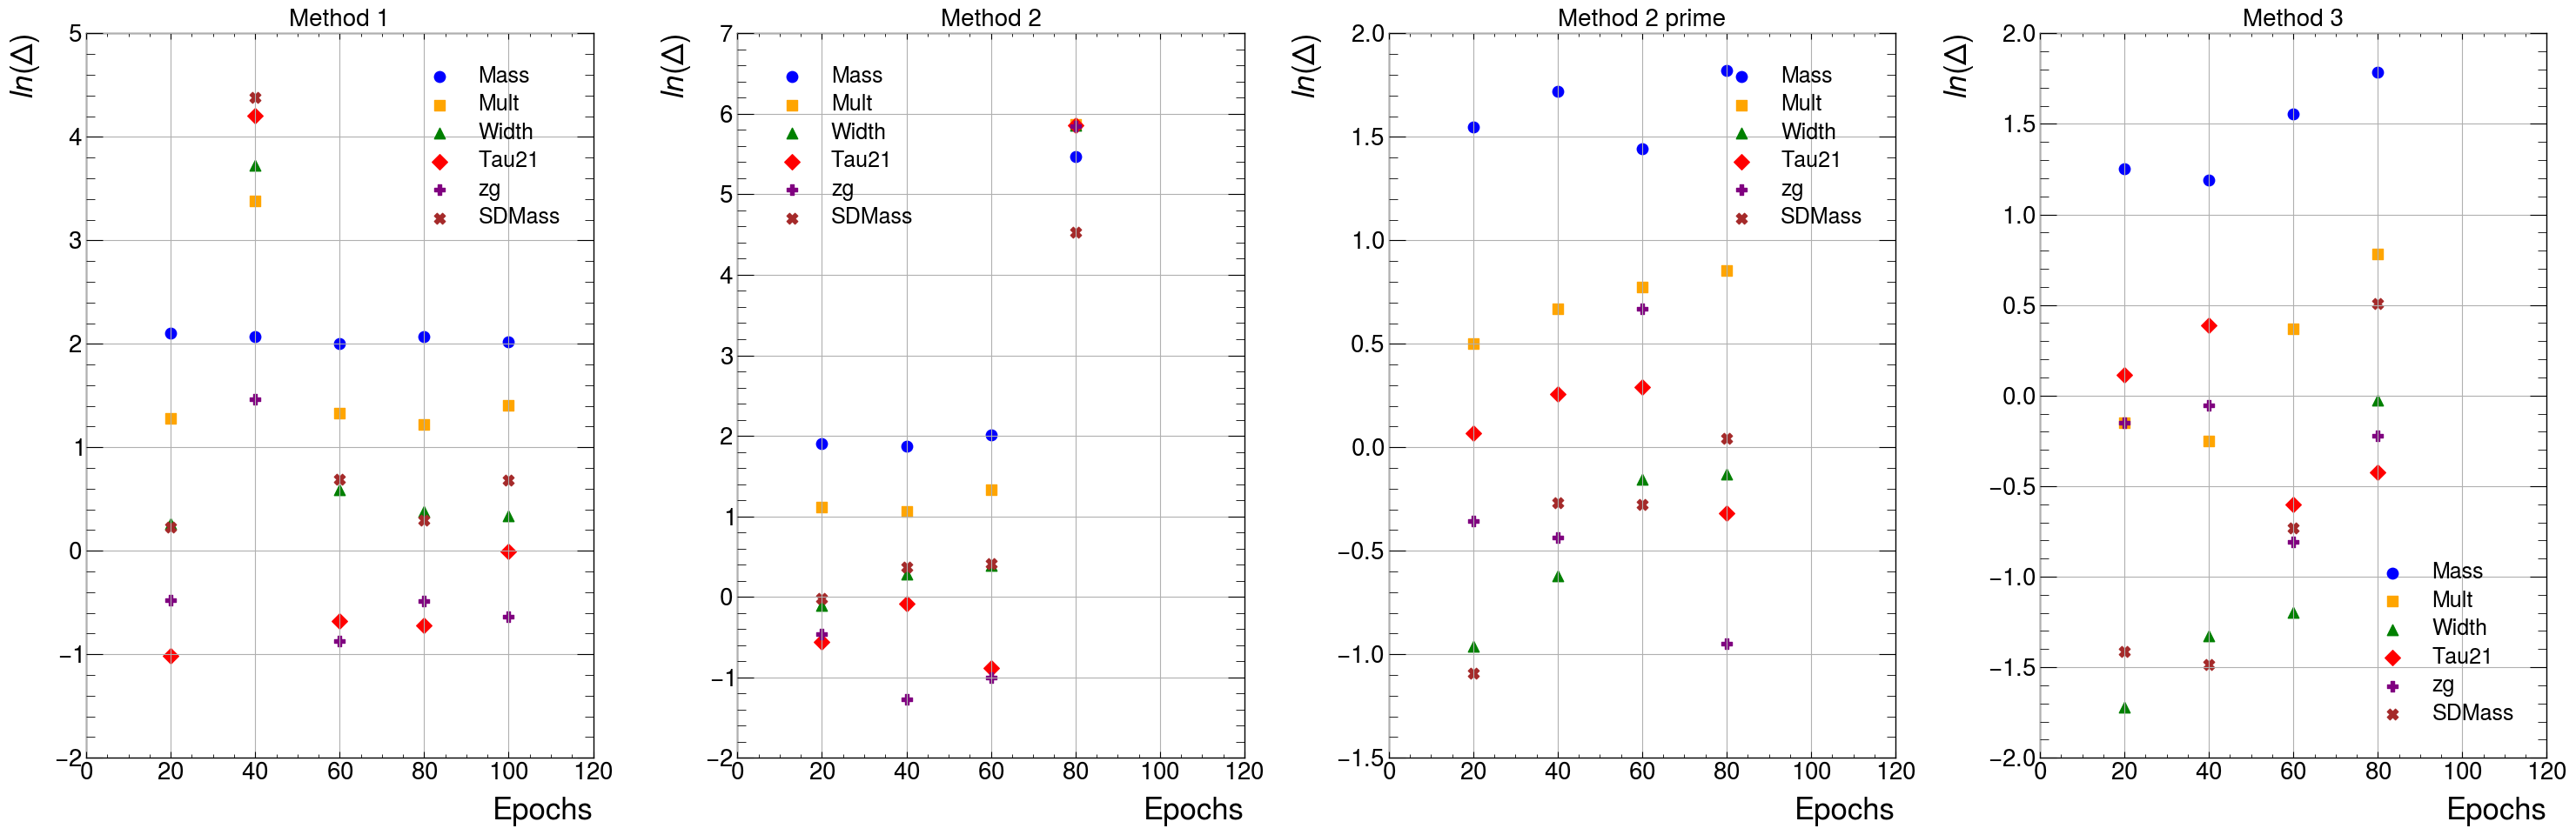

In [228]:
hep.style.use('ATLAS')
plt.rcParams.update({
    'font.size': 20,            # General font size
    'axes.titlesize': 20,       # Title font size
    'axes.labelsize': 25,       # X and Y axis label font size
    'xtick.labelsize': 20,      # X tick label font size
    'ytick.labelsize': 20,      # Y tick label font size
    'legend.fontsize': 18,      # Legend font size
    'figure.titlesize': 18      # Figure title font size
})


epochs=np.array([20,40,60,80,100])
vars=all_scores['m1']['epochs_100'].keys()
markers={'Mass':'o','Mult':'s','Width':'^','Tau21':'D','zg':'P','SDMass':'X'}
colors = {
    'Mass': 'blue', 
    'Mult': 'orange', 
    'Width': 'green', 
    'Tau21': 'red', 
    'zg': 'purple', 
    'SDMass': 'brown'
}
fig, axes = plt.subplots(1,4, figsize=(30,10))
for (method,i) in zip(['m1','m2','m2_p','m3'],range(4)):
    plotted_vars = set()

    for e in epochs:
        for var in vars:
            color = colors[var]
            marker = markers[var]
            label = var if var not in plotted_vars else None  # Label only once per variable
            axes[i].scatter(
                e, 
                np.log(all_scores[method]['epochs_' + str(e)][var]), 
                marker=marker, 
                color=color, 
                label=label,
                s=80
            )
            plotted_vars.add(var)
    if method[-1]=='p':

        axes[i].set_title('Method 2 prime')
    else:
        axes[i].set_title('Method '+ method[-1])
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel(r'$ln(\Delta)$')
    axes[i].set_xlim(0,120)
    axes[i].grid()

for ax in axes:
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    
plt.tight_layout()
plt.show()




In [230]:
all_scores['m2']

{'epochs_100': {'Mass': nan,
  'Mult': nan,
  'Width': nan,
  'Tau21': nan,
  'zg': nan,
  'SDMass': nan},
 'epochs_20': {'Mass': 6.681228889967224,
  'Mult': 3.0472718762507185,
  'Width': 0.90028793603763,
  'Tau21': 0.569195948627199,
  'zg': 0.630217803667311,
  'SDMass': 0.9767046160955831},
 'epochs_40': {'Mass': 6.464774458203567,
  'Mult': 2.8975722957718837,
  'Width': 1.3306032598593005,
  'Tau21': 0.9142398033300274,
  'zg': 0.2800898402551509,
  'SDMass': 1.4456536632466082},
 'epochs_60': {'Mass': 7.513003397323006,
  'Mult': 3.7977494102053266,
  'Width': 1.4781271575405832,
  'Tau21': 0.4124366211311319,
  'zg': 0.3668739818463984,
  'SDMass': 1.5133403431586498},
 'epochs_80': {'Mass': 236.42173103018126,
  'Mult': 352.5853915557331,
  'Width': 350.0118493300579,
  'Tau21': 348.39873377096535,
  'zg': 347.88148579958346,
  'SDMass': 92.30541847698807}}